In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
#!wget https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip
#import shutil
#shutil.unpack_archive('ISIC_2020_Training_JPEG.zip', 'data/')


In [2]:

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
%matplotlib inline
#from keras.preprocessing import image
import tensorflow.keras.applications.densenet as dense
import seaborn as sns

In [3]:
train_img_dir = 'drive/MyDrive/Vision/data/train/'
train = pd.read_csv('drive/MyDrive/Vision/data/ISIC_2020_Training_GroundTruth_v2.csv')


## Function to read the images, reduce its size to 128x128 and normalize its pixel values

In [4]:
import cv2
def read_img(img):
  my_img=cv2.imread(img)
  my_img=cv2.resize(my_img,(128,128))
  my_img=my_img/255.0
  
  return my_img
print(len(train))

33126


## We saw in the EDA that our data is highly imbalanced. So we use this data augmentation function to augment our data

In [5]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

## We use 5000 samples of Benign Images for training.
## We augment the samples of melanoma such that for each image 8 augmented images of melanoma for making the dataset balanced.

In [ ]:
from tqdm import tqdm
data=[]
labels=[]
counts=0
with tqdm(total=5000) as pbar:
  for i in range(len(train)):
      if train.target.iloc[i] == 0:
        counts=counts+1
        if counts<=5000:

          #print(train_img_dir+train['image_name'].iloc[i]+'.jpg')
          data.append(read_img(train_img_dir+train['image_name'].iloc[i]+'.jpg'))
          labels.append(train['target'].iloc[i])
          pbar.update(1)
print(len(data))

with tqdm(total=584) as pbar:

  for i in range(len(train)):
    if train.target.iloc[i] == 1:
      img=read_img(train_img_dir+train['image_name'].iloc[i]+'.jpg')
      pbar.update(1)
      for j in range (0,8):
        data.append(data_augmentation(img))
        labels.append(train['target'].iloc[i])

print(len(data))
#df=pd.DataFrame(data)
#df.columns=['images']
#df['target']=labels

100%|██████████| 5000/5000 [40:58<00:00,  2.03it/s]


5000


100%|██████████| 584/584 [04:16<00:00,  2.27it/s]

9672


## Convert the augmented data and labels 
## Dump them into pickle file so that we can use them in other models as well. 

In [ ]:
data=np.array(data)
labels=np.array(labels)

In [ ]:
import pickle
with open('drive/MyDrive/datax.pkl','wb') as f:
  pickle.dump(data, f)

with open('drive/MyDrive/labelsx.pkl','wb') as f:
  pickle.dump(labels, f)


## Loading the saved data and corresponding labels

In [6]:
data=[]
labels=[]
import pickle
with open('drive/MyDrive/datax.pkl','rb') as f:
  data=pickle.load(f)

with open('drive/MyDrive/labelsx.pkl','rb') as f:
  labels=pickle.load(f)



## Split the data into training testing and validation
## Training data percentage = 70%
## Validation data percentage= 10%
## Testing data percentage= 10%

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,labels,test_size=0.3,random_state=42, shuffle=True)

x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5,random_state=42, shuffle=True)



"train_gen = pd.DataFrame({'image_dir': x_train, 'target': y_train})\nval_gen = pd.DataFrame({'image_dir': x_val, 'target': y_val})\ntest_gen=pd.DataFrame({'image_dir': x_test, 'target': y_test})\ntest_gen"

## For saving memory

In [ ]:
del data
del labels

## OUR MODEL

## Input shape = 128x128

## Conv2D= 2
## Max_Pooling layers= 2
## Dense Layers = 2
## Flatten layer= 1
## Dropout of 0.5 to prevent from overfitting

## Optimizer Adam
## Loss= Binary Crossentropy 
## Activation Function= Sigmoid 



In [ ]:
model = tf.keras.models.Sequential()

# Convolutional & Max Pooling layers

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(128,128,3)))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.5))
# Flatten & Dense layers

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

# performing binary classification
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
                loss = tf.keras.losses.binary_crossentropy,
                metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 32)        0

## Training the model and saving the weights

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="drive/MyDrive/Vision/CNN_Model.hdf5", verbose=1, save_best_only=True)
nb_epochs = 50

#CallBacks Function
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
early_stop=EarlyStopping(monitor="val_loss",
                         patience=10,
                         mode="auto",)

callbacks=[early_stop,checkpointer]

hist=model.fit(
    x_train,y_train, validation_data=[x_val,y_val],
    epochs=nb_epochs,
    callbacks=callbacks,
    )




Epoch 1/50
212/212 [==============================] - ETA: 0s - loss: 0.7472 - accuracy: 0.5517
Epoch 1: val_loss improved from inf to 0.64045, saving model to drive/MyDrive/Vision/weights.hdf5
212/212 [==============================] - 20s 35ms/step - loss: 0.7472 - accuracy: 0.5517 - val_loss: 0.6404 - val_accuracy: 0.6382
Epoch 2/50
210/212 [============================>.] - ETA: 0s - loss: 0.5944 - accuracy: 0.6871
Epoch 2: val_loss improved from 0.64045 to 0.54547, saving model to drive/MyDrive/Vision/weights.hdf5
212/212 [==============================] - 6s 27ms/step - loss: 0.5946 - accuracy: 0.6873 - val_loss: 0.5455 - val_accuracy: 0.7285
Epoch 3/50
210/212 [============================>.] - ETA: 0s - loss: 0.5339 - accuracy: 0.7424
Epoch 3: val_loss improved from 0.54547 to 0.49019, saving model to drive/MyDrive/Vision/weights.hdf5
212/212 [==============================] - 6s 27ms/step - loss: 0.5326 - accuracy: 0.7430 - val_loss: 0.4902 - val_accuracy: 0.7884
Epoch 4/50
21

## We get a final accuracy score of 95.08% on the training data
## We get a final accuracy score of 93.87% on the validation data

## Plotting the accuracy 

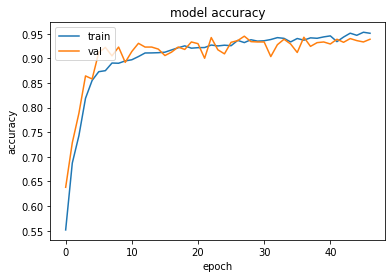

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plotting the model loss

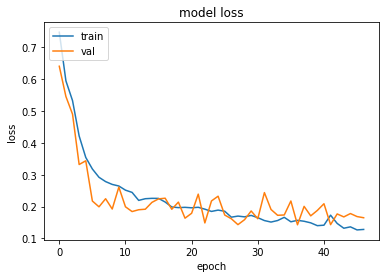

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_pred=model.predict(x_test)
for x in range(len(y_pred)):
  if y_pred[x]<0.5:
    y_pred[x]=0
  else:
    y_pred[x]=1

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[728,  41],
       [ 54, 628]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       769
           1       0.94      0.92      0.93       682

    accuracy                           0.93      1451
   macro avg       0.93      0.93      0.93      1451
weighted avg       0.93      0.93      0.93      1451

